In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

### Brief Explanation of the Format of Tensorflow Modules
- tf.Graph represents a collection of tf.Operations
- Operations come from writing out equations
- There is a default **graph**: tf.get_default_graph()
    + any new operations are added to this graph
- The result of a tf.Operation is a tf.Tensor holding the resulting values

In [2]:
# create a tf.Tensor
n_values = 32
x = tf.linspace(-3.0,3.0, n_values)

In [3]:
# Build a session to execute the graph

sess = tf.Session()
result = sess.run(x)

print(result)

sess.close()

[-3.         -2.80645156 -2.61290312 -2.41935492 -2.22580647 -2.03225803
 -1.83870971 -1.64516139 -1.45161295 -1.25806451 -1.06451619 -0.87096786
 -0.67741942 -0.48387098 -0.29032278 -0.09677434  0.0967741   0.29032254
  0.48387098  0.67741919  0.87096763  1.06451607  1.25806427  1.45161295
  1.64516115  1.83870935  2.03225803  2.22580624  2.41935444  2.61290312
  2.80645132  3.        ]


In [4]:
# We can also start an interactive session, so that we can evaluate statements on the spot

sess = tf.InteractiveSession()

x.eval()

array([-3.        , -2.80645156, -2.61290312, -2.41935492, -2.22580647,
       -2.03225803, -1.83870971, -1.64516139, -1.45161295, -1.25806451,
       -1.06451619, -0.87096786, -0.67741942, -0.48387098, -0.29032278,
       -0.09677434,  0.0967741 ,  0.29032254,  0.48387098,  0.67741919,
        0.87096763,  1.06451607,  1.25806427,  1.45161295,  1.64516115,
        1.83870935,  2.03225803,  2.22580624,  2.41935444,  2.61290312,
        2.80645132,  3.        ], dtype=float32)

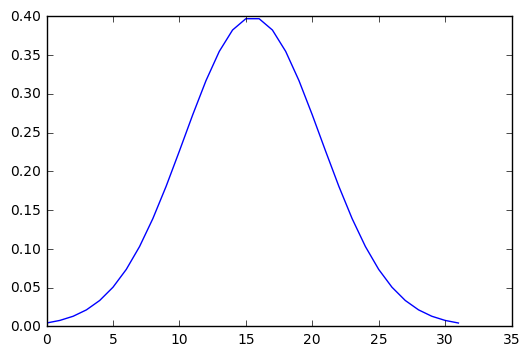

In [5]:
# Now we will use tf.Operations to generate a 
#      Gaussian Distribution from our linear space x

sigma = 1.0
mean = 0.0
z = (tf.exp(tf.neg(tf.pow(x-mean, 2.0) / (2.0 * tf.pow(sigma, 2.0)))) * 
    (1.0 / (sigma * tf.sqrt(2.0 * 3.1415))))

# By default, new operations are added to the default graph,
#     but we can also force operations to be placed on any graph

assert z.graph is tf.get_default_graph()

plt.plot(z.eval())

In [6]:
# finding the shape of a tensor (without computing it in the graph?)

print(tf.shape(z).eval())

[32]


In [7]:
# Can also use the tf.pack function to to combine tensors

print(tf.pack([tf.shape(z), tf.shape(z), [3], [4]]).eval())

[[32]
 [32]
 [ 3]
 [ 4]]


In [8]:
# Let's create a two-dimensional gaussian using the combined tensors

z_2d = tf.matmul(tf.reshape(z, [n_values, 1]), tf.reshape(z, [1, n_values]))

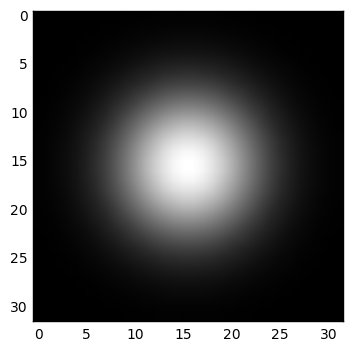

In [9]:
plt.imshow(z_2d.eval(), cmap = "gray")

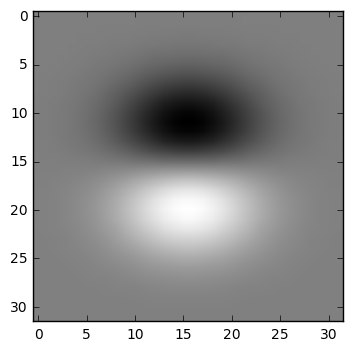

In [10]:
# Creating a gabor patch

x = tf.reshape(tf.sin(tf.linspace(-3.0,3.0,n_values)), [n_values,1])
y = tf.reshape(tf.ones_like(x), [1,n_values])
z = tf.mul(tf.matmul(x,y), z_2d)

plt.imshow(z.eval(), cmap = "gray")

In [11]:
# Listing all the operations of a graph

ops = tf.get_default_graph().get_operations()
print([op.name for op in ops])

['LinSpace/start', 'LinSpace/stop', 'LinSpace/num', 'LinSpace', 'sub/y', 'sub', 'Pow/y', 'Pow', 'Pow_1/x', 'Pow_1/y', 'Pow_1', 'mul/x', 'mul', 'truediv', 'Neg', 'Exp', 'Sqrt/x', 'Sqrt', 'mul_1/x', 'mul_1', 'truediv_1/x', 'truediv_1', 'mul_2', 'Shape', 'Shape_1', 'Shape_2', 'pack/2_1', 'pack/3_1', 'pack', 'Reshape/shape', 'Reshape', 'Reshape_1/shape', 'Reshape_1', 'MatMul', 'LinSpace_1/start', 'LinSpace_1/stop', 'LinSpace_1/num', 'LinSpace_1', 'Sin', 'Reshape_2/shape', 'Reshape_2', 'ones_like/Shape', 'ones_like/Const', 'ones_like', 'Reshape_3/shape', 'Reshape_3', 'MatMul_1', 'Mul']


In [12]:
# Creating a generic function for computing the Gabor Patch

def gabor(n_values = 32, sigma=1.0, mean=0.0):
    x = tf.linspace(-3.0, 3.0, n_values)
    z = (tf.exp(tf.neg(tf.pow(x-mean, 2.0) / (2.0 * tf.pow(sigma, 2.0)))) * 
        (1.0 / (sigma * tf.sqrt(2.0 * 3.1415))))
    gauss_kernel = tf.matmul(tf.reshape(z, [n_values,1]), tf.reshape(z, [1,n_values]))
    
    x = tf.reshape(tf.sin(tf.linspace(-3.0,3.0,n_values)), [n_values, 1])
    y = tf.reshape(tf.ones_like(x), [1, n_values])
    gabor_kernel = tf.mul(tf.matmul(x,y), gauss_kernel)
    return gabor_kernel

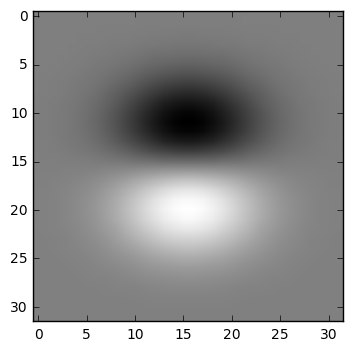

In [13]:
plt.imshow(gabor().eval(), cmap = "gray")

In [14]:
# Add a convolving function, which will combine the functions above with an image provided to it

def convolve(img, W):
    # The W matrix is only 2D, but conv2d will need a 4d tensor
    # height x width x n_input x n_output
    
    if len(W.get_shape()) == 2:
        dims = W.get_shape().as_list() + [1, 1]
        W = tf.reshape(W, dims)
        
    if len(img.get_shape()) == 2:
        # num x height x width x channels
        dims = [1] + img.get_shape().as_list() + [1]
        img = tf.reshape(img, dims)
    elif len(img.get_shape()) == 3:
        dims = [1] + img.get_shape().as_list()
        img = tf.reshape(img, dims)
        # if the image is 3 channels, then our convolution kernel
        # needs to be repeated for each channel
        W = tf.concat(2, [W, W, W])
        
    # Stride is how many values to skip for the dimensions of
    # num, height, width, channels
    convolved = tf.nn.conv2d(img, W,
                            strides=[1, 1, 1, 1], padding = 'SAME')
    return convolved

(768, 1024)


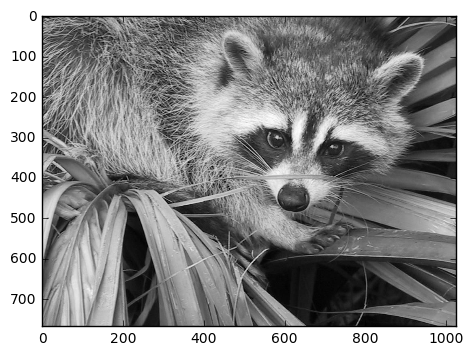

In [19]:
# Load an image
from scipy import misc
img = misc.face(gray=True)
plt.imshow(img, cmap = 'gray')
print(img.shape)

In [20]:
# Create placeholder for our graph which can store any input:

x = tf.placeholder(tf.float32, shape = img.shape)

# And a graph which can convolve our image with a gabor

out = convolve(x, gabor())

# Now we send the image and compute the result
result = tf.squeeze(out).eval(feed_dict={x: img})

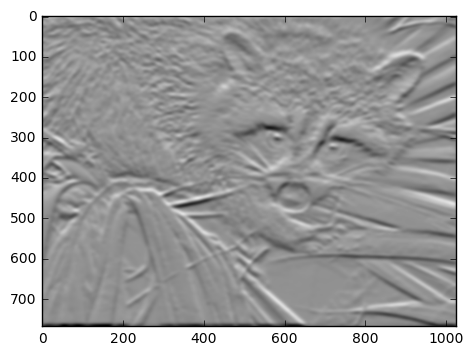

In [22]:
plt.imshow(result, cmap = 'gray')